### Load the necessary libraries and modules


In [68]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import (
    SelectKBest, f_classif, chi2, mutual_info_classif,
    RFE, RFECV, SelectFromModel, VarianceThreshold
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [50]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import shap

# Load the dataset

- The data has 100 rows and 154 columns with 151 numerical columns, 1 categorical column(RATING_TYPE), 1 unstructured data column(string_values) and 1 categorical with order column(Rating)

In [7]:
data_url = "https://github.com/Banking-Analytics-Lab/MultimodalFusionRatings/blob/main/Data/Artificial_Data.xlsx?raw=true"

# Load the dataset

df_1 = pd.read_excel(data_url)

print("dataset is loaded successfully.\n")

# checking first five rows of the data

print(df_1.head())

dataset is loaded successfully.

  RATING_TYPE Rating  FundaIndxint  FundaIndxsga  monthvwretd  monthvwretx  \
0       Fitch     A+      0.150659     -0.420047    -0.846934     0.560226   
1     Moody's     BB     -0.015715      0.139204    -0.045250    -0.912128   
2       Fitch     BB     -1.330074      0.001814    -2.564342     0.997115   
3       Fitch    BBB     -0.025288      0.755935     1.142726    -0.235319   
4     Moody's     AA      1.343168      1.933543    -1.896747     0.467780   

   monthewretd  monthewretx  monthsprtrn  monthspindx  ...   at_turn  \
0     0.579303    -0.578314    -0.225006    -0.415867  ... -0.810215   
1     0.497292    -0.910558     1.207592    -0.104050  ...  1.201837   
2     0.762847    -0.870865     0.230487     0.515273  ...  0.578919   
3     0.637967    -1.611961     0.432309     1.194182  ... -0.067498   
4    -0.442432     1.349705     0.541002     0.096545  ...  0.795701   

   rect_turn  pay_turn  sale_invcap  sale_equity   rd_sale  adv_s

In [8]:
# Inspecting the data

# Extract the columns and data types
- 151 numerical columns belongs to 'float64' dtype while the remaining categorical and text colums are objects.

In [9]:

col_data_types = df_1.dtypes
print(f"The data types of the columns are:\n\n{col_data_types}\n")

The data types of the columns are:

RATING_TYPE       object
Rating            object
FundaIndxint     float64
FundaIndxsga     float64
monthvwretd      float64
                  ...   
rd_sale          float64
adv_sale         float64
staff_sale       float64
accrual          float64
string_values     object
Length: 154, dtype: object



# Basic descriptive statistics

In [10]:
print(f"Descriptive Stats for the dataframe:\n\n{df_1.describe()}\n")

Descriptive Stats for the dataframe:

       FundaIndxint  FundaIndxsga  monthvwretd  monthvwretx  monthewretd  \
count    100.000000    100.000000   100.000000   100.000000   100.000000   
mean      -0.067201      0.075317     0.010728     0.127477     0.093248   
std        1.017370      1.029466     1.091580     1.093258     1.111350   
min       -2.318068     -2.339597    -3.478169    -2.277950    -2.572931   
25%       -0.733156     -0.587366    -0.681876    -0.528532    -0.636587   
50%       -0.150513      0.100186     0.020146     0.141856     0.208633   
75%        0.537932      0.750813     0.613014     0.704034     0.806156   
max        3.061095      3.253985     2.539258     2.616700     3.174442   

       monthewretx  monthsprtrn  monthspindx  monthCAP1RET  monthCAP2RET  ...  \
count   100.000000   100.000000   100.000000    100.000000    100.000000  ...   
mean      0.032180    -0.026623     0.107747      0.166456     -0.016642  ...   
std       1.088224     1.025100   

# Observations based on the data description
- Based on the descriptive stats, it seems the data is more or less pre-processed and doesn't have any significant outliers. The standard deviation for majority of the columns are with in +1SD. Min and Max values are b/w -3 to 3. So, the scaling of the variables is already done in the data.

In [11]:
# We will check for outliers in the columns to understand the data quality.
for col in df_1.select_dtypes(include='float64').columns:
    Q1 = df_1[col].quantile(0.25)
    Q3 = df_1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df_1[(df_1[col] < lower_bound) | (df_1[col] > upper_bound)]

    print(f"\nOutliers in column '{col}':")
    print(outliers[[col]])


Outliers in column 'FundaIndxint':
    FundaIndxint
9       3.061095
22      2.783938

Outliers in column 'FundaIndxsga':
    FundaIndxsga
53      3.253985

Outliers in column 'monthvwretd':
    monthvwretd
62    -3.478169

Outliers in column 'monthvwretx':
    monthvwretx
48     2.573325
71     2.616700

Outliers in column 'monthewretd':
    monthewretd
44     3.174442

Outliers in column 'monthewretx':
    monthewretx
17    -3.568205

Outliers in column 'monthsprtrn':
    monthsprtrn
49    -2.712490
56    -2.529337
64    -2.647253

Outliers in column 'monthspindx':
    monthspindx
7      2.453842
99     2.564058

Outliers in column 'monthCAP1RET':
    monthCAP1RET
73      3.094049

Outliers in column 'monthCAP2RET':
Empty DataFrame
Columns: [monthCAP2RET]
Index: []

Outliers in column 'monthCAP3RET':
    monthCAP3RET
10      3.141967

Outliers in column 'monthCAP4RET':
    monthCAP4RET
71     -3.388428

Outliers in column 'monthCAP5RET':
    monthCAP5RET
82      2.363633

Outliers i

# Understanding the proprotion of the outliers in each column


In [12]:
outlier_perc = {}

for col in df_1.select_dtypes(include='float64').columns:

    Q1 = df_1[col].quantile(0.25)
    Q3 = df_1[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    l_outlier = len(df_1.loc[(df_1[col] < lower_bound)  ,col])
    u_outlier = len(df_1.loc[(df_1[col] > upper_bound)  ,col])

    outlier_count = l_outlier + u_outlier

    percentage_outlier = outlier_count * 100/len(df_1)


    outlier_perc[col] = percentage_outlier

    print(f"{col}:{(percentage_outlier)}")

FundaIndxint:2.0
FundaIndxsga:1.0
monthvwretd:1.0
monthvwretx:2.0
monthewretd:1.0
monthewretx:1.0
monthsprtrn:3.0
monthspindx:2.0
monthCAP1RET:1.0
monthCAP2RET:0.0
monthCAP3RET:1.0
monthCAP4RET:1.0
monthCAP5RET:1.0
monthCAP6RET:0.0
monthCAP7RET:0.0
monthCAP8RET:0.0
monthCAP9RET:0.0
monthCAP10RET:2.0
monthtotval:1.0
monthtotcnt:0.0
monthusdval:1.0
monthusdcnt:1.0
monthprtcnt:3.0
monthtotret:0.0
monthtotind:0.0
monthcapret:1.0
monthcapind:0.0
monthincret:0.0
monthincind:0.0
SPIndvwretd:1.0
SPIndvwretx:3.0
SPIndewretd:0.0
SPIndewretx:0.0
SPIndtotval:0.0
SPIndtotcnt:1.0
SPIndusdval:1.0
SPIndusdcnt:0.0
SPIndspindx:1.0
SPIndsprtrn:1.0
SPporvwretd:0.0
SPporvwretx:2.0
SPporewretd:1.0
SPporewretx:0.0
SPportotval:3.0
SPportotcnt:4.0
SPporusdval:1.0
SPporusdcnt:0.0
SPporspindx:1.0
SPporsprtrn:0.0
usind2CRSPMEV1:0.0
usind2CRSPMEG1:0.0
usind2CRSPLCV1:2.0
usind2CRSPLCG1:0.0
usind2CRSPMIV1:0.0
usind2CRSPMIG1:0.0
usind2CRSPSCV1:1.0
usind2CRSPSCG1:1.0
usind2CRSPMEVT:1.0
usind2CRSPMEGT:0.0
usind2CRSPLCV

# Distribution of outlier percentage across the data
- Except for one variable which have 5% and 7 variables which have 3% outliers,
the remianing variables are well with in the tolerance limit. So, outliers are not creating any major issues in the data.

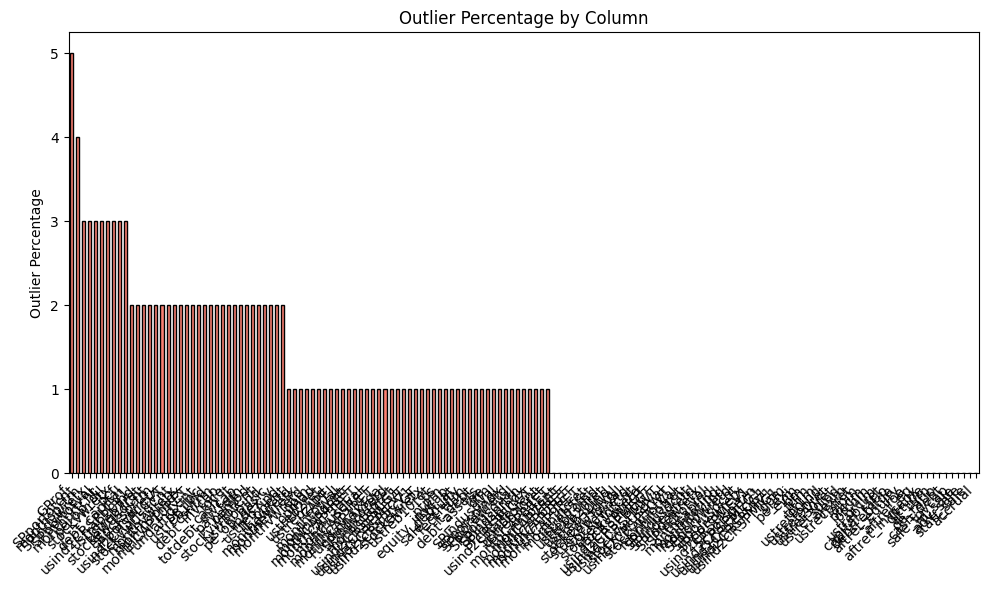

In [13]:

outlier_series = pd.Series(outlier_perc).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
outlier_series.plot(kind='bar', color='salmon', edgecolor='black')
plt.ylabel("Outlier Percentage")
plt.title("Outlier Percentage by Column")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check for missing values

- There are no missing values in the data. The data seems ideal which is not the case usually in real world.

In [14]:

print(f"\nMissing Values:")
missing_data = df_1.isnull().sum()
missing_perc = (missing_data / len(df_1)) * 100
missing_df = pd.DataFrame({
    'missing_count': missing_data,
    'missing_percentage': missing_perc
})
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_count', ascending=False)
print(missing_df)


Missing Values:
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []


# Check Skewness in the data
- As per the stats of the data skewness, the data is fairly symmetric and therefore requires no intervention.

In [15]:
skew_data = df_1.select_dtypes(include='float64').skew().sort_values(ascending=False)

print(f"The skew data is:\n{skew_data.describe()}")

The skew data is:
count    151.000000
mean       0.003518
std        0.241398
min       -0.723803
25%       -0.128086
50%        0.005824
75%        0.164727
max        0.570753
dtype: float64


# correlation matrix
- No pairs are highly correlated as analysed by setting up a threshold of 0.9. Therefore, there is no strong relationship among the features.
- There are 0 high correlation pairs as analysed below. Changing the threshold to 0.4 results in 2 pairs.

In [16]:
corr_df = df_1.select_dtypes(include='float64').corr()

# create correlation matrix as a dataframe
corr_matrix = pd.DataFrame(corr_df)

#print(corr_matrix.head())

# Set a threshold
threshold = 0.9

# Find correlated pairs above the threshold
high_corr = (corr_df.abs() > threshold) & (corr_df.abs() < 1.0)

# Extract the column pairs
high_corr_pairs = []

for col in high_corr.columns:
    corr_features = high_corr.index[high_corr[col]].tolist()

    for row in corr_features:
        if (row, col) not in high_corr_pairs and (col, row) not in high_corr_pairs:
            high_corr_pairs.append((row, col))


# Print the pairs and their correlation values
for row, col in high_corr_pairs:
    print(f"{row} ↔ {col} : correlation = {corr_df.loc[row, col]:.2f}")


# visualize correlation features

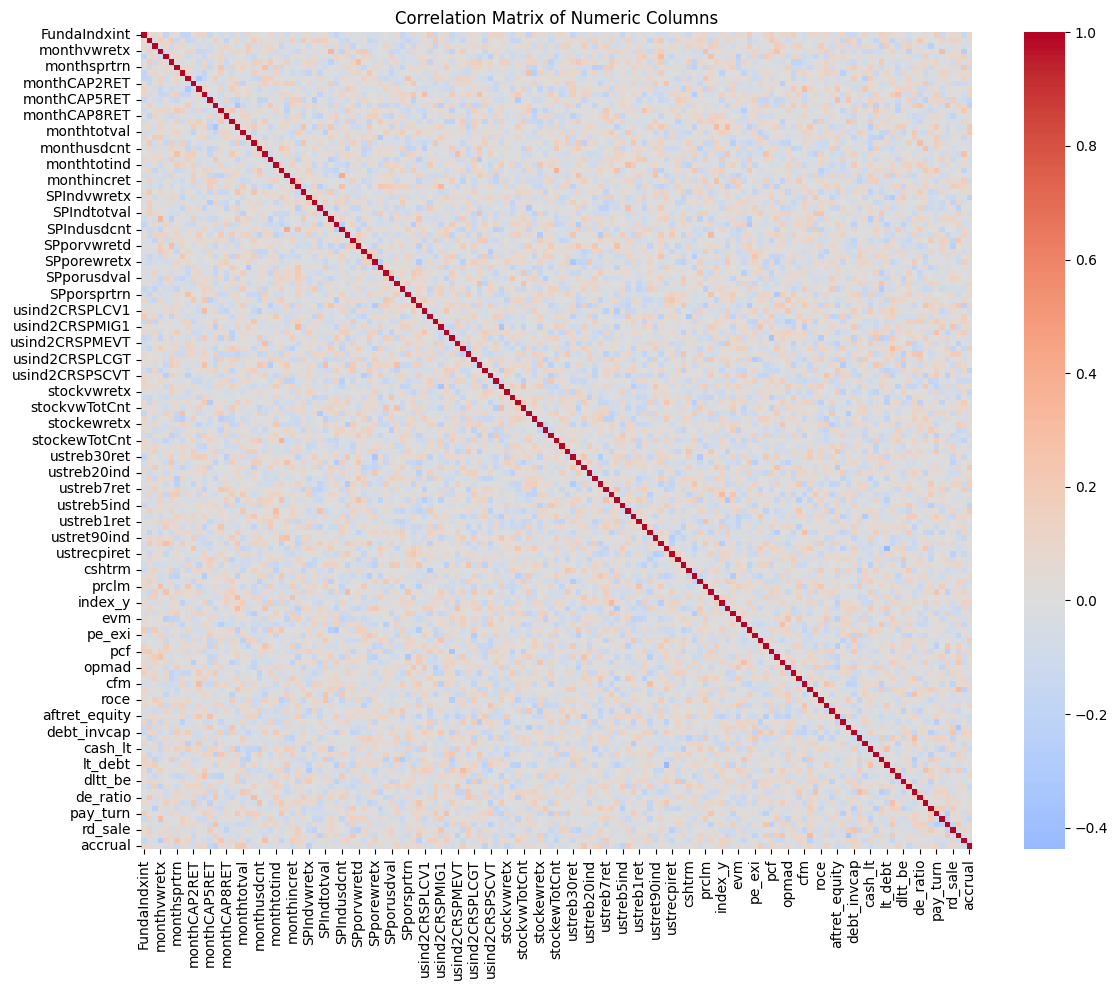

In [17]:
# Step 3: Visualize it as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title("Correlation Matrix of Numeric Columns")
plt.tight_layout()
plt.show()

# Target Variable Selection
- Based on the analysis of the data, the target variable will be 'Rating'. The 'RATING_TYPE' variable which represents rating agencies can be used if the rating agencies will have different 'Rating' standards. But, in this data, the ratings of each rating agencies are of the same type. If they would have been different where Moody's have different rating scale as compared to S&P's and Fitch, then we would have chosen a new variable- 'Risk_Scale' as the target variable to eliminate the subjectivity of the rating agencies using a matrix mapping of the different rating agencies.
But since the data consists of same rating standard for all the 3 rating agenceis, it doesn't need a new target variable. We will convert the 'Rating' to numeric rating after mapping the original rating to a risk scale.

# Feature Selection
- Based on the target variable, correlation and the domain knowledg, the feature variables will be the financial ratios and unstructured text as present in the data.
The rest of the ratios are not important considering that the company credit rating is dependent on the financial information. The stock index, bond index returns are important when the target variable would have been 'Future_Performance'.

In [18]:
# Taking only financial rations as structured variables as the other like index returns/bond market returns are not
#important
structured_cols = ['bm','evm','pe_op_basic','pe_op_dil','pe_exi','pe_inc','ps','pcf','npm','opmbd','opmad','gpm','ptpm','cfm','roa','roe','roce','aftret_eq','aftret_invcapx','aftret_equity','GProf','equity_invcap','debt_invcap','totdebt_invcap','capital_ratio','cash_lt','debt_at','debt_ebitda','lt_debt','cash_debt','lt_ppent','dltt_be','debt_assets','debt_capital','de_ratio','at_turn','rect_turn','pay_turn','sale_invcap','sale_equity','rd_sale','adv_sale','staff_sale','accrual'
]

In [19]:
# New dataframe with Target Variable as Rating, financial ratios as structured ratios and
#string values as unstructured(text) variable

df = df_1[['Rating'] + structured_cols + ['string_values']]

# Encode the 'Rating' Variable to numerical rating for modelling
- Since the rating has inherent order and in business, it is interpreted as a symbol of risk measurement, it is essential to map them to risk and then to a numeric value.
- Since we only have ratings from AAA to BB, we are mapping them from Lowest Risk to Highest Risk. The Highest Risk should not be taken in literal sense as the highest risk usaully occurs for C and below Rating.
- For eg: AAA is the highest rating and lowest risk. The jump b/w AAA and the second best rating AA+ is different than the jump b/w AA+ and AA.

In [20]:
rating_to_risk = {
                'AAA': 'Lowest Risk',
                'AA+': 'Low Risk',
                'AA': 'Low Risk',
                'A+': 'Medium Risk',
                'A': 'Medium Risk',
                'BBB+': 'High Risk',
                'BBB': 'Highest Risk',
                'BB': 'Highest Risk'
            }

# Risk category to numerical mapping (ordered by risk level)
risk_to_numeric = {
    'Lowest Risk': 0,
    'Low Risk': 1,
    'Medium Risk': 2,
    'High Risk': 3,
    'Highest Risk': 4,
    'In Default': 5
}

# for rating column, map it to risk category
if 'Rating' in df.columns:
    print("Converting credit ratings to risk categories...")

    # Convert credit rating to risk category
    risk_cat = df['Rating'].map(rating_to_risk)

    # Now convert risk category to numeric
    rating_numeric = risk_cat.map(risk_to_numeric)

   # Credit Rating -> Risk Category -> Numerical Mapping
    for rating, risk in rating_to_risk.items():
        numeric = risk_to_numeric[risk]
        print(f"  {rating:>3} -> {risk:<12} -> {numeric}")

   # Target distribution after encoding
    risk_counts = risk_cat.value_counts()
    numeric_counts = pd.Series(rating_numeric).value_counts().sort_index()

    for risk_cat, count in risk_counts.items():
        numeric_val = risk_to_numeric[risk_cat]
        print(f"  {risk_cat:<12} ({numeric_val}): {count:>4} samples")


Converting credit ratings to risk categories...
  AAA -> Lowest Risk  -> 0
  AA+ -> Low Risk     -> 1
   AA -> Low Risk     -> 1
   A+ -> Medium Risk  -> 2
    A -> Medium Risk  -> 2
  BBB+ -> High Risk    -> 3
  BBB -> Highest Risk -> 4
   BB -> Highest Risk -> 4
  Highest Risk (4):   29 samples
  Medium Risk  (2):   26 samples
  Low Risk     (1):   25 samples
  Lowest Risk  (0):   10 samples
  High Risk    (3):   10 samples


# Distribution of Target Variable
- The distribution reflects that the samples are not severly imbalanced. Numeric Rating with 0 & 3
have 10 samples each and Numeric Rating with 1, 2 & 4 have 25,26 and 29 samples respectively.

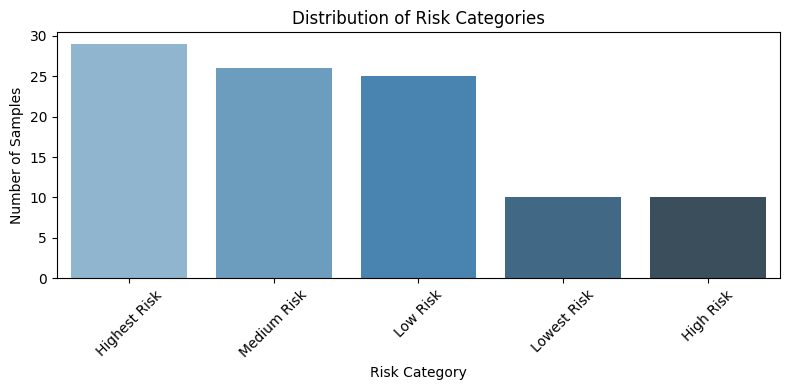

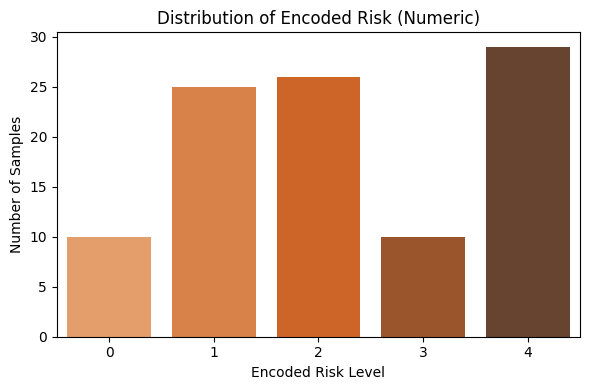

In [21]:
# Plot distribution of risk categories
plt.figure(figsize=(8, 4))
sns.barplot(x=risk_counts.index, y=risk_counts.values, palette="Blues_d")
plt.title("Distribution of Risk Categories")
plt.ylabel("Number of Samples")
plt.xlabel("Risk Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot distribution of encoded numeric risk
plt.figure(figsize=(6, 4))
sns.barplot(x=numeric_counts.index.astype(str), y=numeric_counts.values, palette="Oranges_d")
plt.title("Distribution of Encoded Risk (Numeric)")
plt.ylabel("Number of Samples")
plt.xlabel("Encoded Risk Level")
plt.tight_layout()
plt.show()

In [22]:
# Replace the original 'Rating' column with 'rating_numeric'
df['rating_numeric'] = rating_numeric

# Drop the original 'Rating' column
df = df.drop(columns=['Rating'])


# Correlation of the new input features with the new target variable

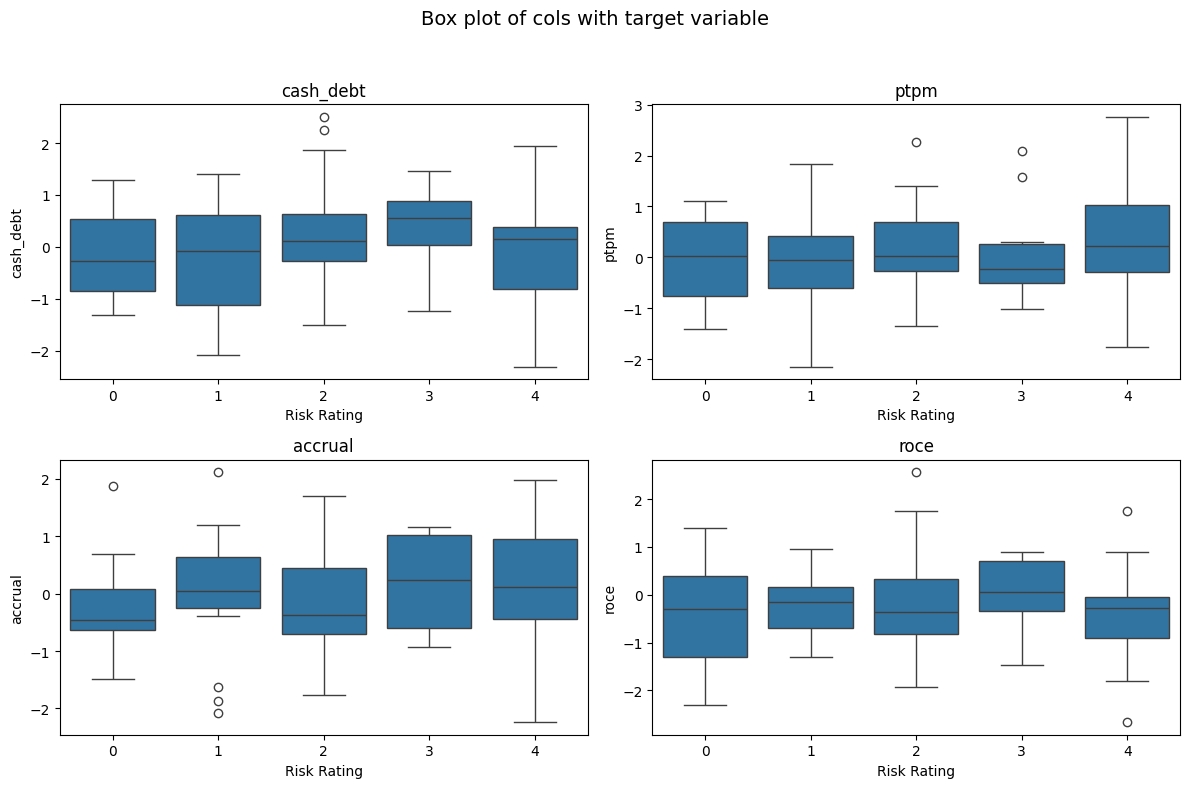

In [23]:

# Randomly select 4 numeric columns (excluding the target)
feature_cols = df.select_dtypes(include='float64').columns
sampled_cols = random.sample(list(feature_cols), 4)

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Box plot of cols with target variable', fontsize=14)

# Plot each feature in a subplot
for ax, col in zip(axes.flatten(), sampled_cols):
    sns.boxplot(x='rating_numeric', y=col, data=df, ax=ax)
    ax.set_title(f'{col}')
    ax.set_xlabel('Risk Rating')
    ax.set_ylabel(col)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()

# NLP for converting the unstructured text column with embeddings
- A quick check on the stats of the column 'string_values' suggests that the texts are repeating and there are only 5 unique text statments. This may be as the data is artifical and does not cover the real-world data.
- Sentiment analysis on such text may not yield good results and therefore, we will use embeddings to capture the semantics to make better use of the information.
- There's not enough data to do topic modelling and hence it is not useful here.

In [24]:
# Basic descriptive stats
df['string_values'].describe()

,string_values
count,100
unique,5
top,The company reported a steady increase in reve...
freq,31


In [25]:
# Distribution of the text data

# Count of the unique values of the text data
- Since most of the text data is neutral to positive, there is non- significant variation in the sentiment of the data and therefore sentiment analysis will not suit this data


In [26]:
df['string_values'].value_counts().head(10)

,count
string_values,
"The company reported a steady increase in revenue, reflecting strong market demand.",31
"Challenges remain in the supply chain, but strategic investments in logistics are improving efficiencies.",23
"The outlook remains positive, with expected growth in both domestic and international markets.",23
"Earnings before interest and taxes improved significantly from last year, driven by cost reduction measures.",14
"Despite market volatility, the firm's financial position is strong, with solid liquidity and manageable debt levels.",9


# Sentiment Analysis
- By using https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english model, I have tried calculating the sentiment label and score, it doesn't have significant variation.
    and therefore, sentiment analysis will not be useful in prediction.

In [27]:
from transformers import pipeline

# Load pretrained sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Example text column
texts = df['string_values'].tolist()

# Get sentiment predictions
sentiments = sentiment_pipeline(texts)

# Extract scores into DataFrame
df['sentiment_label'] = [s['label'] for s in sentiments]
df['sentiment_score'] = [s['score'] for s in sentiments]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


# Transformer based embeddings
- We will load the small model 'all-MiniLM-L6-v2' to calculated the embeddings of the text.
But since the dimension of the vector is 384, we will reduce them to 10 dimensions using PCA and scale the values
so that they match the scale of the other features.


In [28]:

# 1. Load model and encode
model = SentenceTransformer('all-MiniLM-L6-v2')
texts = df['string_values'].astype(str).tolist()
embeddings = model.encode(texts, show_progress_bar=True)

# 2. Reduce dimensionality with PCA
n_components = 10
pca = PCA(n_components=n_components)
embeddings_pca = pca.fit_transform(embeddings)

# 3. Scale PCA output to range [-3, 3]
scaler = MinMaxScaler(feature_range=(-3, 3))
embeddings_scaled = scaler.fit_transform(embeddings_pca)

# 4. Convert to DataFrame and merge back to df
embedding_df = pd.DataFrame(embeddings_scaled, columns=[f'emb_{i+1}' for i in range(n_components)])
df = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

# Predictive Modelling
- Since we are dealing with credit ratings, we will use classification models to predict the ratings.
- we have made numeric classes of ratings after mapping the original ratings to risk categories.
- We will do GBM model training for this exercise.

In [43]:
# starting with structured features only


X = df[structured_cols]
y = df['rating_numeric']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [44]:
# define models and hyperparameter grid

models = {
    'GBM': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [15, 31, 63],
            'max_depth': [-1, 5, 10]
        }
    }

}


In [45]:
# loop through models and tune hyperparameters

structured_results = []

for name, mp in models.items():
    print(f"Running model: {name}")

    search = RandomizedSearchCV(
        mp['model'],
        mp['params'],
        n_iter=10,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)

    print(f"Best parameters for {name}: {search.best_params_}")
    best_model = search.best_estimator_

    # Evaluate
    y_pred = best_model.predict(X_test)
    print(f"Accuracy on test set for {name}: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    structured_results.append({
        'Model': name,
        'Accuracy': acc
    })


Running model: GBM
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for GBM: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}
Accuracy on test set for GBM: 0.2000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.25      0.40      0.31         5
           2       0.20      0.20      0.20         5
           3       0.00      0.00      0.00         2
           4       0.14      0.17      0.15         6

    accuracy                           0.20        20
   macro avg       0.12      0.15      0.13        20
weighted avg       0.16      0.20      0.17        20

Running model: LightGBM
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

In [46]:
structured_results_df = pd.DataFrame(structured_results).sort_values(by='Accuracy', ascending=False)
print("\nStructured Feature Model Comparison:")
print(structured_results_df)


Structured Feature Model Comparison:
      Model  Accuracy
0       GBM       0.2
1  LightGBM       0.2


In [32]:
# Now training using text-only embedding features

In [33]:
# text embeddings features dataframe
X_text = df[[f"emb_{i}" for i in range(1, 11)]]
y = df['rating_numeric']







In [34]:
# 2. Train-test split
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

In [38]:
X_text

,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10
0,3.000000,-2.999999,-2.545593,-2.483617,-3.0,-3.000000,-3.000000,-3.000000,-2.999999,-3.0
1,-3.000000,-2.408966,-2.825063,-2.901246,-3.0,-2.999998,-2.999998,-2.999999,-2.999999,-3.0
2,-2.999999,-2.408966,-2.825061,-2.901244,-3.0,-2.999998,-3.000000,-3.000000,-2.999999,-3.0
3,-2.999998,-2.408965,-2.825063,-2.901245,-3.0,-2.999998,-3.000000,-3.000000,-2.999999,-3.0
4,-2.999998,-2.408966,-2.825063,-2.901245,-3.0,-2.999998,-3.000000,-3.000000,-2.999999,-3.0
...,...,...,...,...,...,...,...,...,...,...
95,0.083000,3.000000,-2.365529,-2.999999,-3.0,-2.999998,-3.000000,-3.000000,-2.999999,-3.0
96,0.083000,3.000000,-2.365529,-2.999999,-3.0,-2.999998,-3.000000,-3.000000,-2.999999,-3.0
97,3.000000,-3.000000,-2.545594,-2.483617,-3.0,-2.999997,-3.000000,-3.000000,-3.000000,-3.0
98,-2.999998,-2.408966,-2.825063,-2.901246,-3.0,-2.999998,-2.999999,-3.000000,-2.999999,-3.0


In [35]:
# 3. Define models and hyperparameters
models = {
    'GBM_text': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7]
        }
    },
    'LightGBM_text': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [15, 31, 63],
            'max_depth': [-1, 5, 10]
        }
    }
}

In [40]:
# 4. Train, tune and evaluate
text_results = []

for name, mp in models.items():
    print(f"\nTraining {name} on text features...")

    search = RandomizedSearchCV(
        estimator=mp['model'],
        param_distributions=mp['params'],
        n_iter=10,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train_text, y_train_text)
    best_model = search.best_estimator_

    print(f"Best params for {name}: {search.best_params_}")

    y_pred_text = best_model.predict(X_test_text)

    accuracy_text = accuracy_score(y_test_text, y_pred_text)

    print(f"Accuracy for {name}: {accuracy_text:.4f}")
    print(classification_report(y_test_text, y_pred_text))

    text_results.append({
        'Model': name,
        'Accuracy': accuracy_text
    })




Training GBM_text on text features...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for GBM_text: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}
Accuracy for GBM_text: 0.2000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.25      0.40      0.31         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         2
           4       0.67      0.33      0.44         6

    accuracy                           0.20        20
   macro avg       0.18      0.15      0.15        20
weighted avg       0.26      0.20      0.21        20


Training LightGBM_text on text features...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bin

In [41]:
# 5. Summary
text_results_df = pd.DataFrame(text_results).sort_values(by='Accuracy', ascending=False)
print("\nText Feature Model Comparison:")
print(text_results_df)


Text Feature Model Comparison:
           Model  Accuracy
0       GBM_text      0.20
1  LightGBM_text      0.15


In [ ]:
# now train model with structured and text columns

In [52]:
# Step 1: Combine structured + text features
X_combined = pd.concat([X, X_text], axis=1)

# Step 2: Train-test split
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Define models and hyperparameter grids
models = {
    'GBM_combined': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7]
        }
    },
    'LightGBM_combined': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [15, 31, 63],
            'max_depth': [-1, 5, 10]
        }
    }
}

# Step 4: Train and evaluate each model
combined_results = []

for name, mp in models.items():
    print(f"\nTraining {name} on combined features...")

    search = RandomizedSearchCV(
        estimator=mp['model'],
        param_distributions=mp['params'],
        n_iter=10,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train_comb, y_train_comb)
    best_model = search.best_estimator_

    print(f"Best parameters for {name}: {search.best_params_}")

    y_pred = best_model.predict(X_test_comb)

    acc = accuracy_score(y_test_comb, y_pred)
    print(f"Accuracy on test set: {acc:.4f}")
    print(classification_report(y_test_comb, y_pred))

    combined_results.append({
        'Model': name,
        'Accuracy': acc
    })

# Step 5: Summary table
combined_results_df = pd.DataFrame(combined_results).sort_values(by='Accuracy', ascending=False)
print("\Combined Feature Model Comparison:")
print(combined_results_df)



Training GBM_combined on combined features...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for GBM_combined: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Accuracy on test set: 0.2500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         5
           2       0.29      0.40      0.33         5
           3       0.00      0.00      0.00         2
           4       0.38      0.50      0.43         6

    accuracy                           0.25        20
   macro avg       0.13      0.18      0.15        20
weighted avg       0.18      0.25      0.21        20


Training LightGBM_combined on combined features...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

# create confusion matrix based on the combined data
- since the overall data size is jsut 100 rows, the training data is not enough to train the model. As a result, we can see the model is not able to predict the right class for different class ratings.

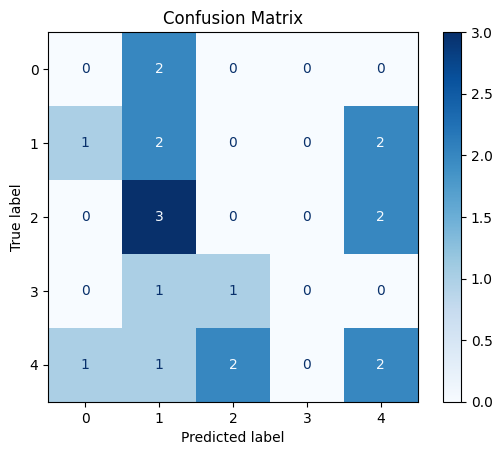

In [69]:
# Generate confusion matrix
cm = confusion_matrix(y_test_comb, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Comparison Report of the performance of models across structured only, text only and combined features


In [70]:
structured_results_df['DataType'] = 'Structured'
text_results_df['DataType'] = 'Text'
combined_results_df['DataType'] = 'Combined'

performance_df = pd.concat([
    structured_results_df,
    text_results_df,
    combined_results_df
], ignore_index=True)


# Visualize the performance
- We can see the performance of the GBM model has increased after considering the unstructured text into the model.

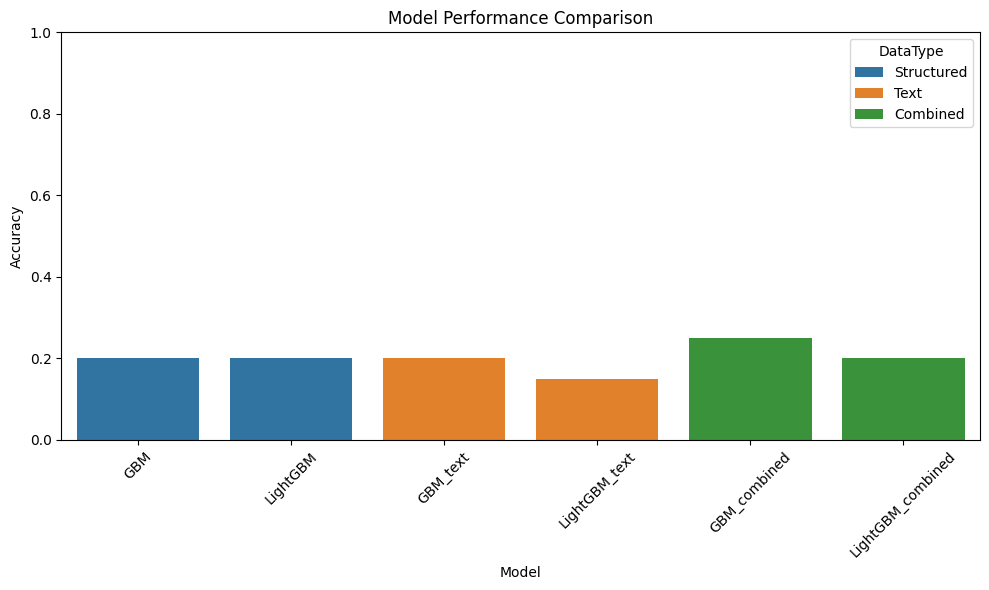

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(data=performance_df, x='Model', y='Accuracy', hue='DataType')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


#SHAP analysis
- side by side view of which features impact different rating classes

(100, 54, 5)


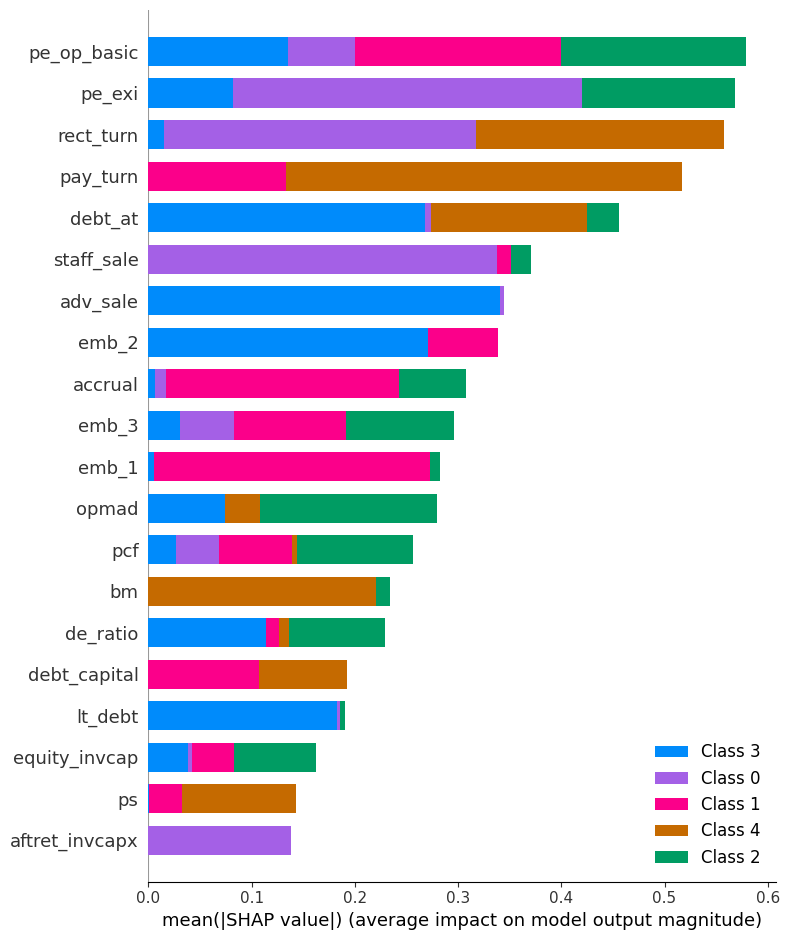

In [56]:
# feature importance using SHAP

# Using GBM for the combined data
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_combined)


# Plot summary
shap.summary_plot(shap_values, X_combined, plot_type="bar")


In [73]:
# comment

# Feature Importance by each class type of the rating
- The rating of low risk class doesn't have much impact from the leverage ratios while the high risk classes does have more impact from the leverage ratios. This confirms the trend that is usaully scene in the real world.

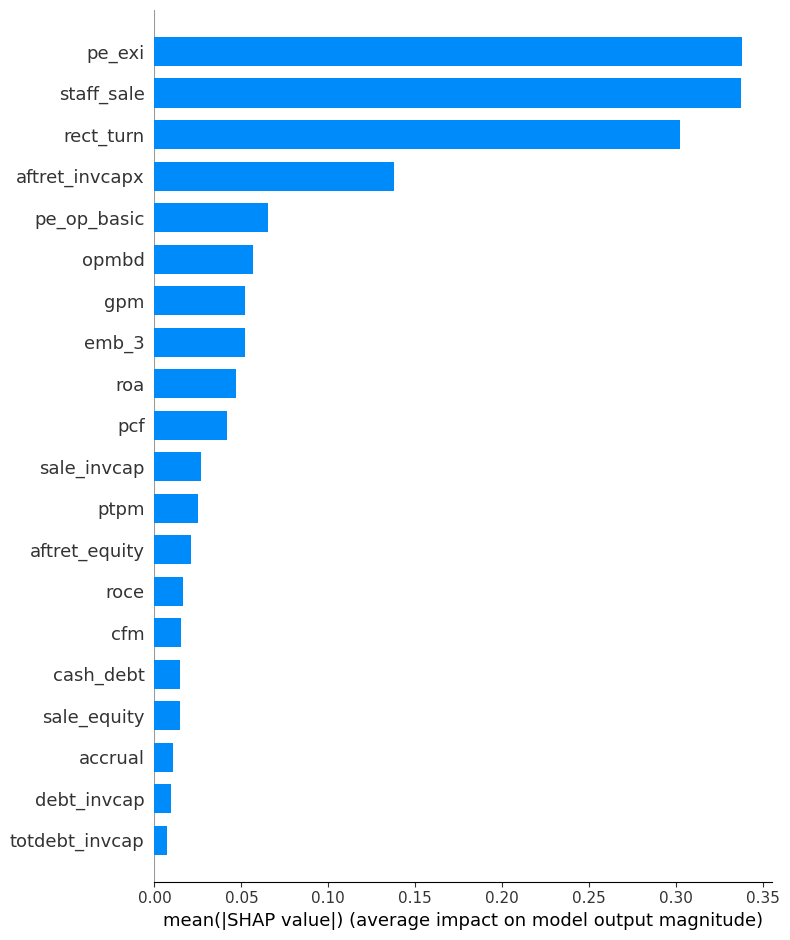

In [67]:
# Split shap values by class
shap_values_by_class = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

# Plot for class 0
shap.summary_plot(shap_values_by_class[0], X_combined, plot_type='bar')